# Figures for PDSW'21 Paper Submission

Glenn K. Lockwood, Alberto Chiusole, Nicholas J. Wright

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import collections
from n10storage.parse import IorOutput
from n10storage.load import load_ior_output_files, load_ior_vs_setsize_results, load_contention_datasets
from n10storage.plot import *

DATASETS = {
    "VAST, compressible": {
        "files": "./ior-scaling-rdma.vast.v3-naive/ior-out.tgz",
    },
    "VAST, incompressible": {
        "files": "./ior-scaling-rdma.vast.v4/ior-out.tgz",
    },
    "VAST IOPS": {
        "files": "./randio/ior-out-T45.tgz",
    },
    "VAST IOPS DirectIO": {
        "files": "./randio.odirect/ior-out-T45.tgz",
    },
    "VAST IOPS vs Set Size": {
        "files": "./randio.vs-size/slurm-*.out.gz",
        "loader": load_ior_vs_setsize_results,
    }
}

datasets = {}
for dataset_name, dataset_args in DATASETS.items():
    loader = dataset_args.get("loader", load_ior_output_files)
    input_file = dataset_args["files"]
    
    csv_file = input_file + ".csv"
    if os.path.isfile(csv_file) and '*' not in csv_file:
        print(f"Loaded {csv_file}")
        datasets[dataset_name] = pandas.read_csv(csv_file)
    else:
        datasets[dataset_name] = loader(input_file)
        if '*' not in csv_file:
            datasets[dataset_name].to_csv(csv_file, index=False)
            print(f"Created {csv_file}")
    
    if loader == load_ior_output_files:
        # drop parts of dataset that have 16 clients - we don't have all the runs for those
        datasets[dataset_name] = datasets[dataset_name][datasets[dataset_name]['nodes'] < 16]
        # drop the 2880-byte transfersize - it causes unexplainable behavior on VAST reads
        datasets[dataset_name] = datasets[dataset_name][datasets[dataset_name]['xfersize'] != 2880]

# verify uniformity of datasets
verify_plot_datasets(datasets)

Loaded ./ior-scaling-rdma.vast.v3-naive/ior-out.tgz.csv
Loaded ./ior-scaling-rdma.vast.v4/ior-out.tgz.csv
Loaded ./randio/ior-out-T45.tgz.csv
Loaded ./randio.odirect/ior-out-T45.tgz.csv
Found 5 runs (160 results) in ./randio.vs-size/slurm-*.out.gz.
VAST, compressible has 1200 results
VAST, incompressible has 1200 results
VAST IOPS has 200 results
VAST IOPS DirectIO has 200 results
VAST IOPS vs Set Size has 120 results


Saved plot to bandwidth-scaling-withcv.pdf


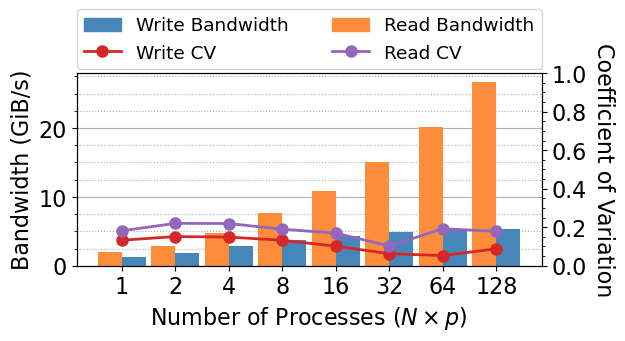

In [3]:
NAIVE_DATASET = datasets["VAST, compressible"]
ax = plot_bw_cv_vs_nproc_bars(NAIVE_DATASET)
ax.get_shared_x_axes().get_siblings(ax)[0].set_ylim(0, 1)
ax.get_shared_x_axes().get_siblings(ax)[0].set_ylabel("Coefficient of Variation", rotation=270, va='bottom')
ax.get_figure().set_size_inches(6, 2.5)
output_file = "bandwidth-scaling-withcv.pdf"
ax.set_xlabel("Number of Processes ($N \\times p$)")
ax.get_figure().savefig(output_file, bbox_inches='tight', transparent=True)
print("Saved plot to {}".format(output_file))

In [4]:
for access in 'write', 'read':
    filt = NAIVE_DATASET['access'] == access
    cv = NAIVE_DATASET[filt].groupby('nproc').std()['bw(mib/s)'] / NAIVE_DATASET[filt].groupby('nproc').mean()['bw(mib/s)']
    max_cv = cv.max()
    print(f"Coefficient of variation for {access}s (max: {max_cv:.3f})")
    print(cv)

Coefficient of variation for writes (max: 0.151)
nproc
1      0.132412
2      0.151432
4      0.148827
8      0.132217
16     0.101345
32     0.062665
64     0.052622
128    0.088254
Name: bw(mib/s), dtype: float64
Coefficient of variation for reads (max: 0.220)
nproc
1      0.181524
2      0.220019
4      0.219220
8      0.189644
16     0.169335
32     0.102098
64     0.192522
128    0.178317
Name: bw(mib/s), dtype: float64


In [5]:
max_naive_bw = {}
for access in 'write', 'read':
    max_naive_bw[access] = NAIVE_DATASET[NAIVE_DATASET['access'] == access].groupby('nproc').mean()['bw(mib/s)'].max()
    print("Max {} bandwidth: {:.2f} GiB/s".format(access, max_naive_bw[access] / 1024.0))
print("Performance read:write ratio is {:.2f}:1".format(max_naive_bw['read'] / max_naive_bw['write']))

Max write bandwidth: 5.35 GiB/s
Max read bandwidth: 26.63 GiB/s
Performance read:write ratio is 4.97:1


Saved plot to bandwidth-xfersize-extremes.pdf


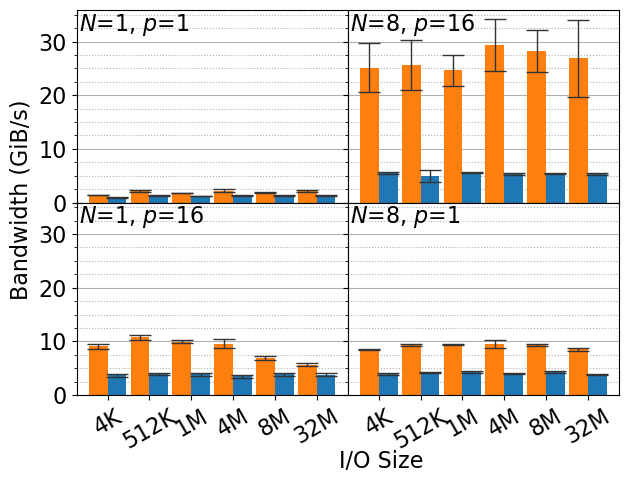

In [6]:
axes = plot_bw_vs_xfersize_extremes(datasets["VAST, compressible"])

output_file = "bandwidth-xfersize-extremes.pdf"
axes.flatten()[0].get_figure().savefig(output_file, bbox_inches='tight', transparent=True)
print("Saved plot to {}".format(output_file))

Saved plot to aging-effects-on-bw.pdf


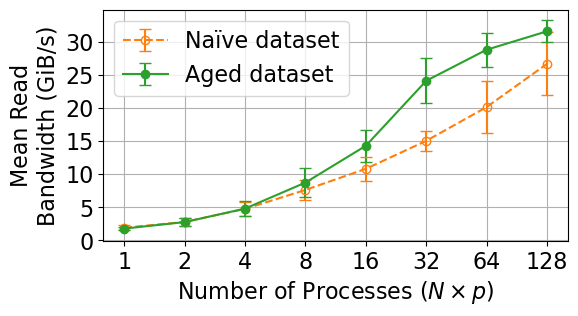

In [7]:
ax = plot_compare_rw_bw_vs_nproc(collections.OrderedDict([
    ("Naïve dataset", datasets["VAST, compressible"]),
    ("Aged dataset", datasets["VAST, incompressible"]),
]), access='r')
ax.set_ylabel(ax.get_ylabel().replace("Mean Bandwidth", "Mean Read\nBandwidth"))
ax.get_figure().set_size_inches(6, 3)
ax.set_xlabel("Number of Processes ($N \\times p$)")

output_file = "aging-effects-on-bw.pdf"
ax.get_figure().savefig(output_file, bbox_inches='tight', transparent=True)
print("Saved plot to {}".format(output_file))

In [8]:
max_naive_bw = {}
for access in 'write', 'read':
    max_naive_bw[access] = datasets["VAST, incompressible"][datasets["VAST, incompressible"]['access'] == access].groupby('nproc').mean()['bw(mib/s)'].max()
    print("Max {} bandwidth: {:.2f} GiB/s".format(access, max_naive_bw[access] / 1024.0))
print("Performance read:write ratio is {:.2f}:1".format(max_naive_bw['read'] / max_naive_bw['write']))

Max write bandwidth: 4.87 GiB/s
Max read bandwidth: 31.54 GiB/s
Performance read:write ratio is 6.48:1


In [9]:
PERLMUTTER_TURNOVER_TBPD = 2200
PERLMUTTER_TURNOVER_TBPS = PERLMUTTER_TURNOVER_TBPD / 86400
PERLMUTTER_TOTAL_TB = 35000
print("Write buffer capacity: {:.0f} TB".format(VAST_DBOX_NVRAM_BUFFER_TBS))
print("QLC capacity:          {:.0f} TB".format(VAST_DBOX_QLC_CAPACITY_TBS))

print("Write buffer to QLC capacity: 1:{:.0f}".format(VAST_DBOX_QLC_CAPACITY_TBS / VAST_DBOX_NVRAM_BUFFER_TBS))

PERLMUTTER_NVRAM_BUFFER_TBS = PERLMUTTER_TOTAL_TB / VAST_DBOX_QLC_CAPACITY_TBS * VAST_DBOX_NVRAM_BUFFER_TBS

print("Perlmutter's {:.0f} TB/day would constantly write at {:.1f} GB/s".format(
    PERLMUTTER_TURNOVER_TBPD,
    PERLMUTTER_TURNOVER_TBPS * 1000))
print("At {:.0f} TB/day, Perlmutter would turn over {:.0f} TB of NVRAM every {:.0f} minutes".format(
    PERLMUTTER_TURNOVER_TBPD,
    PERLMUTTER_NVRAM_BUFFER_TBS,
    PERLMUTTER_NVRAM_BUFFER_TBS / PERLMUTTER_TURNOVER_TBPS / 60
))

Write buffer capacity: 3 TB
QLC capacity:          608 TB
Write buffer to QLC capacity: 1:203
Perlmutter's 2200 TB/day would constantly write at 25.5 GB/s
At 2200 TB/day, Perlmutter would turn over 173 TB of NVRAM every 113 minutes


Saved plot to iops-scaling-scatter.pdf


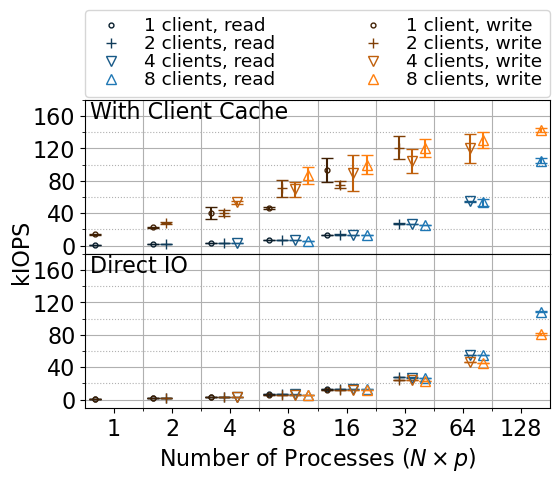

In [10]:
this_plots_datasets = collections.OrderedDict([
    ("With Client Cache", datasets["VAST IOPS"]),
    ("Direct IO",         datasets["VAST IOPS DirectIO"]),
])
axes = plot_all_data(this_plots_datasets, plot_alliops_vs_nproc_errorbar_by_nodect)
axes[0].get_figure().set_size_inches(6, 4.0)
for ax in axes:
    ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=6))
    ax.yaxis.set_minor_locator(matplotlib.ticker.MaxNLocator(nbins=12))
    ax.yaxis.grid(True, which='major')
    ax.yaxis.grid(True, linestyle=":", which='minor')
    ax.set_ylim(-10, 180)
    for child in ax.get_children():
        if isinstance(child, matplotlib.text.Text) and child.get_position()[0] == 0.5 and child.get_text():
            child.set_ha('left')
            child.set_va('top')
            child.set_x(0.01)
            child.set_y(0.99)
axes[-1].set_xlabel("Number of Processes ($N \\times p$)")
output_file = "iops-scaling-scatter.pdf"
axes[0].get_figure().savefig(output_file, bbox_inches='tight', transparent=True)
print("Saved plot to {}".format(output_file))

Performance at largest set size (1024 GiB): 67.0 read KIOPS
Performance at smallest set size (96 GiB): 158.3 read KIOPS
Largest set size is 2.36x slower than smallest
Saved plot to speedup-vs-setsize.pdf


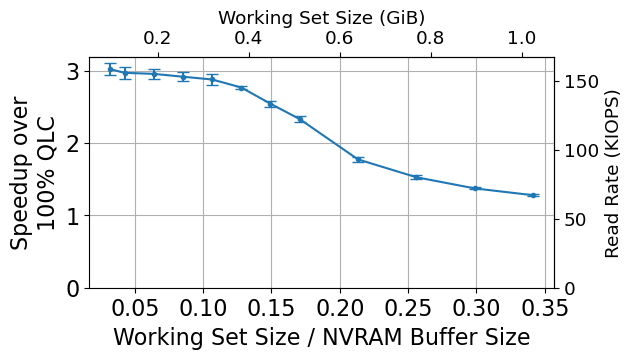

In [11]:
# calculate the performance expected if this run was 100% on QLC
all_qlc_perf = datasets["VAST IOPS"].groupby('nproc').get_group(64).groupby('access').get_group('read')['iops'].mean()

# generate pretty plot
ax = plot_perf_vs_setsize(
    datasets["VAST IOPS vs Set Size"],
    perf_key="iops",
    access="read",
    norm_y_by=all_qlc_perf,
    relativex=True)
ax.get_figure().set_size_inches(6, 3)
ax.set_ylabel("Speedup over\n100% QLC")

# calculate the performance at the two extremes
grouped_dataset = datasets["VAST IOPS vs Set Size"].groupby("access").get_group("read").groupby("setsize_gib_int")
max_set_size = list(grouped_dataset.groups.keys())
min_set_size = min(max_set_size)
max_set_size = max(max_set_size)
max_perf = grouped_dataset.get_group(max_set_size)['iops'].mean()
min_perf = grouped_dataset.get_group(min_set_size)['iops'].mean()

print("Performance at largest set size ({:d} GiB): {:.1f} read KIOPS".format(
    max_set_size,
    max_perf / 1000))
print("Performance at smallest set size ({:d} GiB): {:.1f} read KIOPS".format(
    min_set_size,
    min_perf / 1000))
print("Largest set size is {:.2f}x slower than smallest".format(min_perf / max_perf))

ymin, ymax = ax.get_ylim()
ydelta = ymax - ymin
arrowprops = dict(facecolor='black', shrink=0.15, width=1.0, headwidth=8.0)
ax.annotate(
    "{:.1f} KIOPS".format(max_perf / 1000),
    xy=(max_set_size/VAST_DBOX_NVRAM_BUFFER_TBS, max_perf/all_qlc_perf),
    xytext=(max_set_size/VAST_DBOX_NVRAM_BUFFER_TBS, max_perf/all_qlc_perf - 0.25 * ydelta),
    ha="right",
    va="top",
    arrowprops=arrowprops,
)
ax.annotate(
    "{:.1f} KIOPS".format(min_perf / 1000),
    xy=(min_set_size/VAST_DBOX_NVRAM_BUFFER_TBS, min_perf/all_qlc_perf),
    xytext=(min_set_size/VAST_DBOX_NVRAM_BUFFER_TBS, min_perf/all_qlc_perf - 0.25 * ydelta),
    ha="left",
    va="top",
    arrowprops=arrowprops,
)

# add secondary axes - for clarity?
xaxis2 = ax.secondary_xaxis(
    'top',
    functions=(lambda x: x * VAST_DBOX_NVRAM_BUFFER_TBS, lambda x: x / VAST_DBOX_NVRAM_BUFFER_TBS))
xaxis2.set_xlabel("Working Set Size (GiB)", fontsize='smaller')
xaxis2.tick_params(axis='x', labelsize="smaller")

yaxis2 = ax.secondary_yaxis(
    'right',
    functions=(lambda x: x * all_qlc_perf / 1000, lambda x: x / all_qlc_perf * 1000))
yaxis2.set_ylabel("Read Rate (KIOPS)", fontsize='smaller')
yaxis2.tick_params(axis='y', labelsize="smaller")

output_file = "speedup-vs-setsize.pdf"
ax.get_figure().savefig(output_file, bbox_inches='tight', transparent=True)
print("Saved plot to {}".format(output_file))